In [73]:
from helper_functions import download_data
image_dir_path = download_data(
    source="https://github.com/harshankbansal/pytorch-deep-learning/raw/refs/heads/main/data/pizza_steak_sushi.zip",
    destination="food_dataset"
)

[INFO] data\food_dataset directory exists, skipping download.


## Reading images.

In [74]:
import glob
all_images_path = glob.glob(str(image_dir_path) + '/*/*/*.jpg')

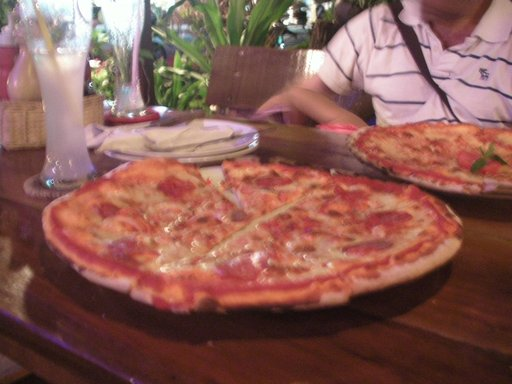

In [75]:
import numpy as np
from PIL import Image


random_image = Image.open(np.random.choice(all_images_path, 1)[0])
random_image

array([[[ 91,  98,  80],
        [ 85,  92,  74],
        [ 92, 101,  80],
        ...,
        [143, 110, 105],
        [111,  77,  75],
        [ 83,  49,  47]],

       [[ 84,  91,  75],
        [ 82,  89,  73],
        [ 93, 102,  83],
        ...,
        [159, 126, 121],
        [134, 100,  98],
        [110,  76,  74]],

       [[ 79,  85,  73],
        [ 81,  87,  75],
        [ 92, 100,  85],
        ...,
        [173, 140, 133],
        [158, 125, 120],
        [142, 109, 104]],

       ...,

       [[ 60,  36,  26],
        [ 59,  35,  23],
        [ 58,  36,  23],
        ...,
        [ 46,  23,  17],
        [ 46,  22,  18],
        [ 45,  21,  19]],

       [[ 57,  34,  26],
        [ 56,  34,  23],
        [ 56,  34,  23],
        ...,
        [ 49,  24,  19],
        [ 49,  24,  20],
        [ 49,  24,  20]],

       [[ 49,  26,  18],
        [ 48,  25,  17],
        [ 50,  28,  17],
        ...,
        [ 50,  25,  20],
        [ 50,  25,  21],
        [ 50,  25,  21]]

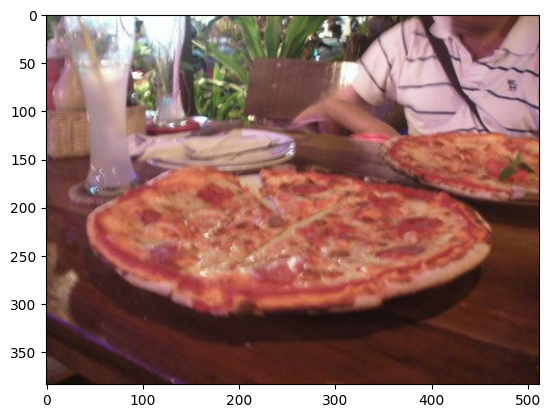

In [76]:
import matplotlib.pyplot as plt
img_as_np = np.asarray(random_image)

plt.imshow(img_as_np)
img_as_np

In [77]:
from torch import nn
from torchvision.transforms.functional import to_tensor

to_tensor(random_image).shape

torch.Size([3, 384, 512])

### Custom Dataset
The following custom class is not needed as torchvision provides an implementation `datasets.ImageFolder` for this kind of data structure 

In [78]:
from torch.utils.data import Dataset
from PIL import Image
from torchvision.transforms.v2 import ToTensor
from pathlib import Path
import os


class CustomImageDataset(Dataset):
    def __init__(self, root_path):
        super().__init__()
        self.root_path = str(root_path)
        self.root_path += ("" if self.root_path.endswith("/") else "/")
        self.class_names = os.listdir(root_path)
        self.class_names.sort()
        self.train_image_transforms = ToTensor()
        self.all_image_paths = glob.glob(self.root_path + '*/*.jpg')

    def __len__(self):
        return len(self.all_image_paths)
    
    def __getitem__(self, index):
        if index >= len(self):
            raise IndexError(f"Index out of range. Size = {len(self)}. Index Requested = {index}")
        
        img_path = Path(self.all_image_paths[index])
        label = img_path.parent.stem
        img = self.train_image_transforms(Image.open(img_path))
        return img, label

In [79]:
train_dataset = CustomImageDataset(image_dir_path / "train")
test_dataset = CustomImageDataset(image_dir_path / "test")

d:\accounts\learning\ai\pytorch\udemy-zth\pytorch-deep-learning\venv\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [80]:
len(train_dataset), len(test_dataset)

(225, 75)

In [81]:
train_dataset.class_names, test_dataset.class_names

(['pizza', 'steak', 'sushi'], ['pizza', 'steak', 'sushi'])

The above is not needed as we can use `torchvision.datasets.ImageFolder` like below

### Trying `datasets.ImageFolder` Dataset

In [82]:
from torchvision import datasets

ds = datasets.ImageFolder(image_dir_path / "train")
len(ds)

225

In [83]:
ds.classes

['pizza', 'steak', 'sushi']

### Creating image transformation script


In [ ]:
from torchvision.transforms.v2 import Resize, RandomHorizontalFlip, ToTensor, Compose, ToPILImage
train_image_transforms = Compose([
    Resize(size=(224, 224)),
    RandomHorizontalFlip(0.5),
    ToTensor(),
])

test_image_transforms = Compose([
    Resize(size=(224, 224)),
    ToTensor(),
])

In [85]:
img_as_tensor = train_image_transforms(random_image)
img_as_np = np.asarray(random_image)
img_as_tensor.shape, img_as_np.shape

(torch.Size([3, 224, 224]), (384, 512, 3))

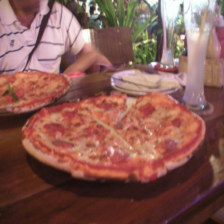

In [ ]:
ToPILImage()(img_as_tensor)

#### Visualize transformation compared to original


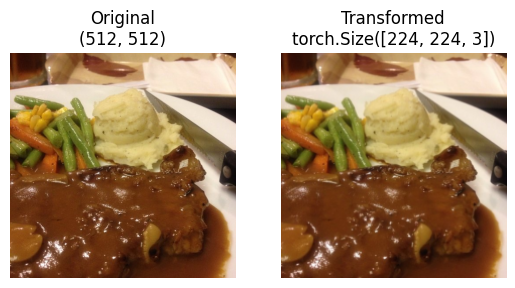

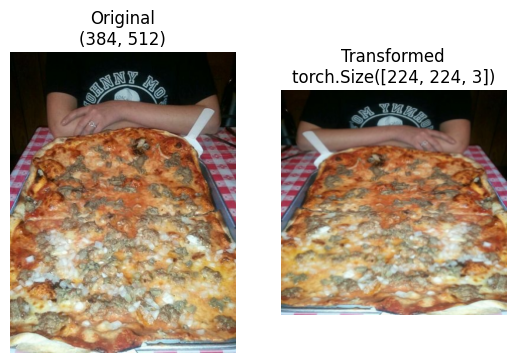

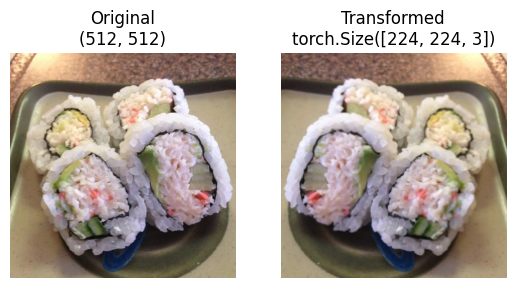

In [87]:
import matplotlib.pyplot as plt
import random

def random_visualize_image_transformations(image_paths, img_tranforms, n=3):
    image_paths = random.sample(image_paths, k=n)
    for image_path in image_paths:
        image = Image.open(image_path)
        tranformed_image = img_tranforms(image).permute(1,2,0)
        fig, ax = plt.subplots(nrows=1, ncols=2)
        ax[0].set_title(f"Original\n{image.size}")
        ax[0].imshow(image)
        ax[0].axis(False)
        
        ax[1].set_title(f"Transformed\n{tranformed_image.shape}")
        ax[1].imshow(tranformed_image)
        ax[1].axis(False)



random_visualize_image_transformations(all_images_path, train_image_transforms)


#### Trying image augmentation
1. https://sebastianraschka.com/blog/2023/data-augmentation-pytorch.html
1. https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/

In [88]:
from torchvision.transforms.v2 import TrivialAugmentWide, Compose, Resize

train_image_transforms = Compose([
    Resize(size=(224, 224)),
    TrivialAugmentWide(num_magnitude_bins=21),
    ToTensor()
])

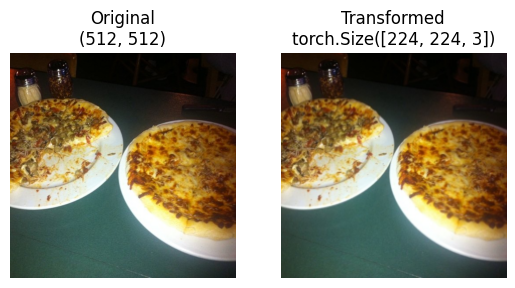

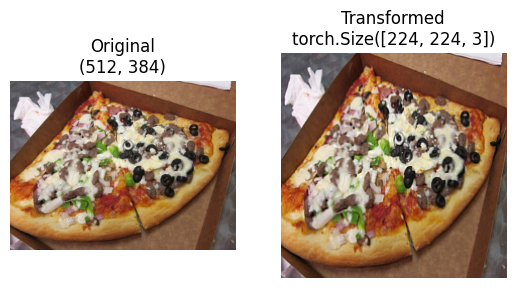

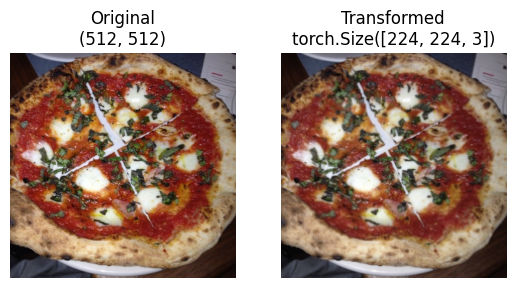

In [89]:
random_visualize_image_transformations(
    all_images_path,
    train_image_transforms
)

## Creating Dataset & DataLoader

In [ ]:
from torchvision import datasets
from torch.utils.data import DataLoader

In [111]:
get_train_dataset = lambda t: datasets.ImageFolder(
    image_dir_path / "train", 
    transform=t
)
get_test_dataset = lambda t: datasets.ImageFolder(
    image_dir_path / "test",
    transform=t
)

In [112]:
train_dataset = get_train_dataset(train_image_transforms)
test_dataset = get_train_dataset(test_image_transforms)
len(train_dataset), len(test_dataset)

(225, 225)

In [92]:
train_dataset.classes

['pizza', 'steak', 'sushi']

#### visualize an image from dataset

In [93]:
img, label = train_dataset[11]
img, train_dataset.classes[label]

(tensor([[[0.1373, 0.1255, 0.1294,  ..., 0.1882, 0.1922, 0.2000],
          [0.1294, 0.1216, 0.1294,  ..., 0.1961, 0.1922, 0.1961],
          [0.1294, 0.1176, 0.1216,  ..., 0.1961, 0.1765, 0.1765],
          ...,
          [0.1020, 0.1216, 0.1490,  ..., 0.4275, 0.4275, 0.4471],
          [0.0980, 0.1294, 0.1647,  ..., 0.4549, 0.4706, 0.5098],
          [0.1020, 0.1333, 0.1765,  ..., 0.4706, 0.5098, 0.5333]],
 
         [[0.6078, 0.6157, 0.6078,  ..., 0.5373, 0.5333, 0.5255],
          [0.6157, 0.6196, 0.6118,  ..., 0.5294, 0.5333, 0.5294],
          [0.6157, 0.6235, 0.6196,  ..., 0.5333, 0.5490, 0.5490],
          ...,
          [0.0706, 0.0745, 0.0784,  ..., 0.1882, 0.1804, 0.1961],
          [0.0627, 0.0745, 0.0902,  ..., 0.2039, 0.2118, 0.2471],
          [0.0588, 0.0784, 0.0980,  ..., 0.2118, 0.2431, 0.2588]],
 
         [[0.0078, 0.0157, 0.0078,  ..., 0.0157, 0.0157, 0.0118],
          [0.0078, 0.0118, 0.0039,  ..., 0.0039, 0.0078, 0.0118],
          [0.0039, 0.0118, 0.0078,  ...,

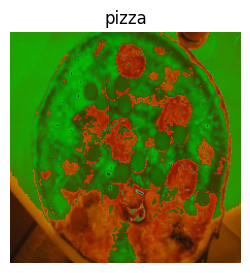

In [94]:
plt.figure(figsize=(3,3))
plt.axis(False)
plt.title(train_dataset.classes[label])
plt.imshow(img.permute(1,2,0))

In [139]:
get_train_dataloader = lambda transformations: DataLoader(
    dataset=get_train_dataset(transformations),
    shuffle=True,
    batch_size=16
)

get_test_dataloader = lambda transformations: DataLoader(
    dataset=get_test_dataset(transformations),
    shuffle=True,
)

In [116]:
train_dataloader = get_train_dataset(train_image_transforms)
test_dataloader = get_train_dataset(test_image_transforms)
len(train_dataloader), len(test_dataloader)

(225, 225)

## Create Models

In [176]:
import torch
from torch import nn
from helper_functions import accuracy_fn, plot_loss_curves, PytorchModelTranier

CLASS_NAMES = train_dataset.classes
NUM_CLASSES = len(CLASS_NAMES)
HIDDEN_UNITS = 10
INPUT_COLOR_CHANNELS = 3
RESIZE_IMAGE_SIZE = 64

device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Model 0: Base Model using simple linear layers - Very Bad Model, so discarded

In [ ]:
# model = nn.Sequential(
#     nn.Flatten(),
#     nn.LazyLinear(out_features=1000),
#     nn.LazyLinear(out_features=100),
#     nn.Linear(in_features=100, out_features=NUM_CLASSES)
# ).to(device)

# loss_fn = nn.CrossEntropyLoss().to(device)
# optimizer = torch.optim.SGD(
#     params=model.parameters(),
#     lr=0.1,
# )

# model_0_trainer = PytorchModelTranier(
#     name="v0-baseline-model",
#     model=model,
#     loss_fn=loss_fn,
#     optimizer=optimizer,
#     test_dataloader=test_dataloader,
#     train_dataloader=train_dataloader,
#     logits_to_pred=lambda logits: torch.softmax(logits, dim=1).argmax(dim=1)
# )

In [99]:
it = iter(train_dataloader)

In [100]:
img_batch, label_batch = next(it)
# img_batch, label_batch
y_logits = model(img_batch)
loss = loss_fn(y_logits, label_batch)
optimizer.zero_grad()
loss.backward()
optimizer.step()

loss
# y_logits

tensor(1.1060, grad_fn=<NllLossBackward0>)

In [101]:
# model_0_trainer.train(1)
# model_0_trainer.plot_losses()

 20%|██        | 1/5 [00:20<01:20, 20.02s/it]

Epoch 1/5 Train Loss: nan | Train Acc: 31.25% Test Loss: nan | Test Acc: 33.33%


 40%|████      | 2/5 [00:27<00:37, 12.61s/it]

Epoch 2/5 Train Loss: nan | Train Acc: 32.50% Test Loss: nan | Test Acc: 33.33%


 60%|██████    | 3/5 [00:34<00:20, 10.12s/it]

Epoch 3/5 Train Loss: nan | Train Acc: 38.75% Test Loss: nan | Test Acc: 33.33%


 80%|████████  | 4/5 [00:41<00:08,  8.84s/it]

Epoch 4/5 Train Loss: nan | Train Acc: 38.75% Test Loss: nan | Test Acc: 33.33%


 80%|████████  | 4/5 [00:45<00:11, 11.44s/it]


KeyboardInterrupt: 

This was extremely poor. So not going to consider this at all

### Model 0: Trying Tiny VGG without augmentation

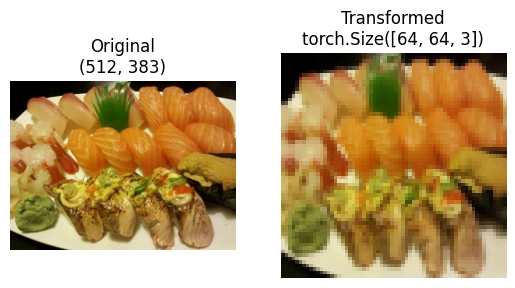

In [ ]:
# Define transformers and Data Loader for Easy Experimentation
from torchvision.transforms.v2 import Resize, Compose, ToImage, ToDtype
train_image_transforms = Compose([
    Resize(size=(RESIZE_IMAGE_SIZE, RESIZE_IMAGE_SIZE)),
    ToImage(),
    ToDtype(torch.float32, scale=True)
])
test_image_transforms = Compose([
    Resize(size=(RESIZE_IMAGE_SIZE, RESIZE_IMAGE_SIZE)),
    ToImage(),
    ToDtype(torch.float32, scale=True)
])

#Test a transformation
random_visualize_image_transformations(
    all_images_path,
    train_image_transforms,
    n=1
)
train_dataloader = get_train_dataloader(train_image_transforms)
test_dataloader = get_test_dataloader(test_image_transforms)

In [213]:
import torchinfo
# Replicating architecture in CNN Explainer website
# It has two Conv Blocks each of which is (Conv+Relu -> Conv+Relu+Pooling)
# And then a fully connected layer
model = nn.Sequential(
    # Conv Block 1
    nn.Sequential(
        nn.Conv2d(
            in_channels=3,
            out_channels=10,
            kernel_size=3,
            stride=1,
            padding=0
        ),
        nn.ReLU(),
        nn.Conv2d(
            in_channels=10,
            out_channels=10,
            kernel_size=3,
            stride=1,
            padding=0
        ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
    ),

    # Conv block 2
    nn.Sequential(
        nn.Conv2d(
            in_channels=10,
            out_channels=10,
            kernel_size=3,
            stride=1,
            padding=0
        ),
        nn.ReLU(),
        nn.Conv2d(
            in_channels=10,
            out_channels=10,
            kernel_size=3,
            stride=1,
            padding=0
        ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
    ),
    #Fully connected layer
    nn.Flatten(),
    # nn.LazyLinear(out_features=8*8*8*8),
    # nn.ReLU(),
    # nn.LazyLinear(out_features=8*8*8),
    # nn.ReLU(),
    # nn.LazyLinear(out_features=8*8),
    # nn.ReLU(),
    # nn.LazyLinear(out_features=8),
    # nn.ReLU(),
    nn.LazyLinear(out_features=NUM_CLASSES)
).to(device)

loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(
    params=model.parameters(),
    lr=0.1,
)

model_0_trainer = PytorchModelTranier(
    name="v0-tiny-vgg",
    model=model,
    loss_fn=loss_fn,
    optimizer=optimizer,
    test_dataloader=test_dataloader,
    train_dataloader=train_dataloader,
    logits_to_pred=lambda logits: torch.softmax(logits, dim=1).argmax(dim=1)
)

torchinfo.summary(model, input_size=next(iter(train_dataloader))[0].shape)

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [16, 3]                   --
├─Sequential: 1-1                        [16, 10, 30, 30]          --
│    └─Conv2d: 2-1                       [16, 10, 62, 62]          280
│    └─ReLU: 2-2                         [16, 10, 62, 62]          --
│    └─Conv2d: 2-3                       [16, 10, 60, 60]          910
│    └─ReLU: 2-4                         [16, 10, 60, 60]          --
│    └─MaxPool2d: 2-5                    [16, 10, 30, 30]          --
├─Sequential: 1-2                        [16, 10, 13, 13]          --
│    └─Conv2d: 2-6                       [16, 10, 28, 28]          910
│    └─ReLU: 2-7                         [16, 10, 28, 28]          --
│    └─Conv2d: 2-8                       [16, 10, 26, 26]          910
│    └─ReLU: 2-9                         [16, 10, 26, 26]          --
│    └─MaxPool2d: 2-10                   [16, 10, 13, 13]          --
├─Flatten: 

In [215]:
# Manual steps for troubleshooting
it = iter(train_dataloader)
img_batch, label_batch = next(it)
y_logits = model(img_batch)

# loss = loss_fn(y_logits, label_batch)
# optimizer.zero_grad()
# loss.backward()
# optimizer.step()

#Print whatever needed

# loss
# img_batch, label_batch
y_logits.shape

torch.Size([16, 3])

 10%|█         | 1/10 [00:01<00:11,  1.32s/it]

Epoch 1/10 Train Loss: 1.0986 | Train Acc: 29.58% Test Loss: 1.0802 | Test Acc: 41.33%


 20%|██        | 2/10 [00:02<00:11,  1.41s/it]

Epoch 2/10 Train Loss: 1.1000 | Train Acc: 34.58% Test Loss: 1.0765 | Test Acc: 41.33%


 30%|███       | 3/10 [00:04<00:10,  1.45s/it]

Epoch 3/10 Train Loss: 1.1040 | Train Acc: 29.17% Test Loss: 1.0863 | Test Acc: 33.33%


 40%|████      | 4/10 [00:05<00:08,  1.45s/it]

Epoch 4/10 Train Loss: 1.0923 | Train Acc: 36.25% Test Loss: 1.0762 | Test Acc: 41.33%


 50%|█████     | 5/10 [00:07<00:06,  1.39s/it]

Epoch 5/10 Train Loss: 1.0898 | Train Acc: 37.08% Test Loss: 1.1039 | Test Acc: 33.33%


 60%|██████    | 6/10 [00:08<00:05,  1.41s/it]

Epoch 6/10 Train Loss: 1.0958 | Train Acc: 38.75% Test Loss: 1.1070 | Test Acc: 33.33%


 70%|███████   | 7/10 [00:09<00:04,  1.41s/it]

Epoch 7/10 Train Loss: 1.0949 | Train Acc: 38.75% Test Loss: 1.1074 | Test Acc: 33.33%


 80%|████████  | 8/10 [00:11<00:02,  1.47s/it]

Epoch 8/10 Train Loss: 1.1014 | Train Acc: 32.50% Test Loss: 1.1115 | Test Acc: 33.33%


 90%|█████████ | 9/10 [00:12<00:01,  1.45s/it]

Epoch 9/10 Train Loss: 1.0894 | Train Acc: 40.83% Test Loss: 1.0869 | Test Acc: 37.33%


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]

Epoch 10/10 Train Loss: 1.0734 | Train Acc: 42.50% Test Loss: 1.0978 | Test Acc: 41.33%


{'model_name': 'v0-tiny-vgg',
 'model_loss': 1.0978492498397827,
 'model_acc': 41.333333333333336}

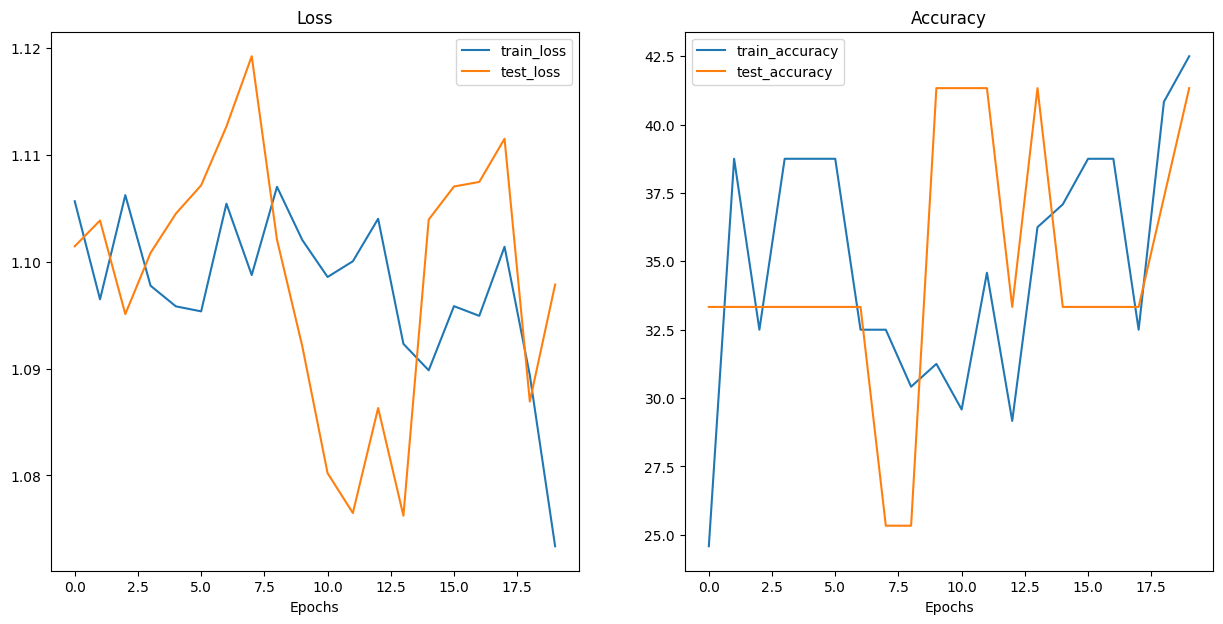

In [217]:
# Train and plot graph
model_0_trainer.train(10)
model_0_trainer.plot_losses()
model_0_eval = model_0_trainer.eval()
model_0_eval